# Fetal Health Classification

**Context**

Reduction of child mortality is reflected in several of the United Nations' Sustainable Development Goals and is a key indicator of human progress.
The UN expects that by 2030, countries end preventable deaths of newborns and children under 5 years of age, with all countries aiming to reduce under‑5 mortality to at least as low as 25 per 1,000 live births.

Parallel to notion of child mortality is of course maternal mortality, which accounts for 295 000 deaths during and following pregnancy and childbirth (as of 2017). The vast majority of these deaths (94%) occurred in low-resource settings, and most could have been prevented.

In light of what was mentioned above, Cardiotocograms (CTGs) are a simple and cost accessible option to assess fetal health, allowing healthcare professionals to take action in order to prevent child and maternal mortality. The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.

**Data**:
This dataset contains 2126 records of features extracted from Cardiotocogram exams, which were then classified by three expert obstetritians into 3 classes:

- Normal
- Suspect
- Pathological

**Features**

- 'baseline value' FHR baseline (beats per minute)
- 'accelerations' Number of accelerations per second
- 'fetal_movement' Number of fetal movements per second
- 'uterine_contractions' Number of uterine contractions per second
- 'light_decelerations' Number of light decelerations per second
- 'severe_decelerations' Number of severe decelerations per second
- 'prolongued_decelerations' Number of prolonged decelerations per second
- 'abnormal_short_term_variability' Percentage of time with abnormal short term variability
- 'mean_value_of_short_term_variability' Mean value of short term variability
- 'percentage_of_time_with_abnormal_long_term_variability' Percentage of time with abnormal long term variability
- 'mean_value_of_long_term_variability' Mean value of long term variability
- 'histogram_width' Width of FHR histogram
- 'histogram_min' Minimum (low frequency) of FHR histogram
- 'histogram_max' Maximum (high frequency) of FHR histogram
- 'histogram_number_of_peaks' Number of histogram peaks
- 'histogram_number_of_zeroes' Number of histogram zeros
- 'histogram_mode' Histogram mode
- 'histogram_mean' Histogram mean
- 'histogram_median' Histogram median
- 'histogram_variance' Histogram variance
- 'histogram_tendency' Histogram tendency

**Target**: 'fetal_health' Tagged as 1 (Normal), 2 (Suspect) and 3 (Pathological)

Source: [Kaggle](https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification)

**Acknowledgements**

Ayres de Campos et al. (2000) SisPorto 2.0 A Program for Automated Analysis of Cardiotocograms. J Matern Fetal Med 5:311-318 (link)

## Import Libraries

In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score

np.random.seed(1234)

## Helper Functions

In [28]:
def save_plot(filename, dpi=300, plot=None):
    """
    Saves the current or provided Matplotlib plot.
    
    :param filename: str, the name of the file to save, should include .png extension
    :param dpi: int, dots per inch, for image quality (300 is high quality)
    :param plot: Matplotlib plot object, if None, saves the current plot
    """
    
    # Set the figure size to a 16:9 ratio
    figure = plt.gcf()  # Get current figure if plot is not specified
    if plot is not None:
        figure = plot.get_figure()
    figure.set_size_inches(16, 9)

    # Save the figure
    figure.savefig(f"./plots/{filename}", dpi=dpi, bbox_inches='tight', format='png')
    print(f"Plot saved in plot directory as '{filename}' with dpi={dpi}")

In [85]:
def model_evaluator(test, predictions, model_name=None):
    """
    Calculates the various model evaluation metrics.
    
    :param test: numpy array, contains the test observations
    :param predictions: numpy array, contains the predicted values made by the model
    :model_name: str, name of the machine learning model
    """
    
    if model_name is None:
        print('Invalid model name, please provide a name for the model')
        return
    
    acccuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions, average="weighted")
    precision = precision_score(y_test, predictions, average="weighted")
    f1_score_value = f1_score(y_test, predictions, average="micro")

    print(f"********* {model_name.upper()} Results *********")
    print("Accuracy    : ", acccuracy)
    print("Recall      : ", recall)
    print("Precision   : ", precision)
    print("F1 Score    : ", f1_score_value)
    
    print()
    print()
    
    print(f"********* {model_name.upper()} Classification Report *********")
    print(classification_report(test, predictions))

In [92]:
def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix', cmap='Blues'):
    """
    Plots a confusion matrix using Seaborn's heatmap.

    :param y_true: Array of true labels.
    :param y_pred: Array of predicted labels.
    :param labels: List of label names for the confusion matrix.
    :param title: Title for the plot.
    :param cmap: Color map for the heatmap.
    """
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    
    save_plot(f"{title}.png")
    plt.show()

## Exploratory Data Analysis

In [34]:
# setting color palette
colors = ['#008450', '#EFB700', '#B81D13']

In [5]:
# importing data
file = './data/fetal_health.csv'

df = pd.read_csv(file)

In [6]:
df.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [8]:
df['fetal_health'].unique()

array([2., 1., 3.])

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


### What is the distribution of the target variable?

Plot saved in plot directory as 'Distribution of the target variable.png' with dpi=300


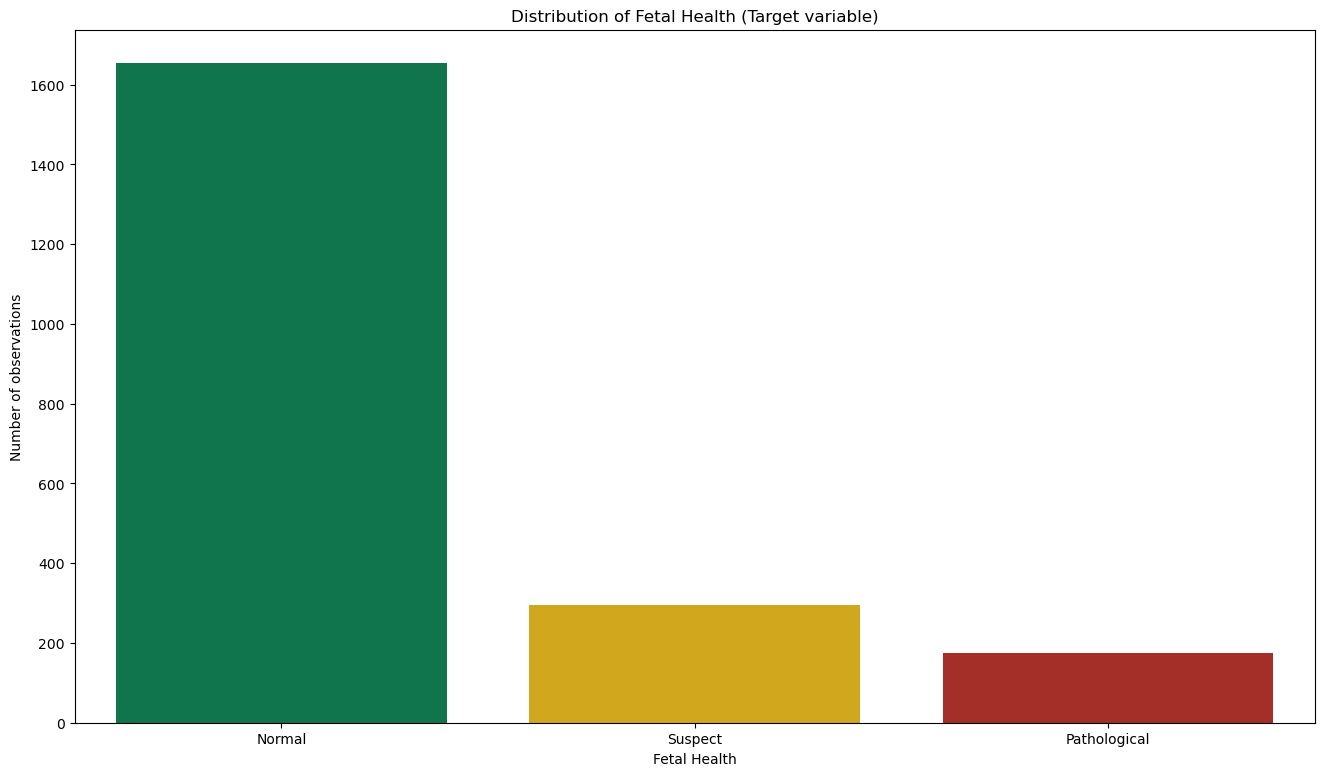

In [32]:
plot = sns.countplot(data=df, x='fetal_health', palette=colors)

# Adjusting x-ticks
plt.xlabel('Fetal Health')
plt.xticks(ticks=[0, 1, 2], labels=['Normal', 'Suspect', 'Pathological'])

plt.title('Distribution of Fetal Health (Target variable)')
plt.ylabel('Number of observations')

# Saving plot
save_plot('Distribution of the target variable.png')

# Disply plot
plt.show()

**Conclusion**: The distribution below shows an imbalance in the dataset. With most of the observations having a fetal health classification of **Normal**. Therefore the following metrics will prove valuable in understanding the performance of the classification models.
- Confusion Matrix
- Precision
- Recall (Sensitivity)
- F1 Score

### What is the relationship between the target variable and other variables?

Plot saved in plot directory as 'Correlation Matrix.png' with dpi=300


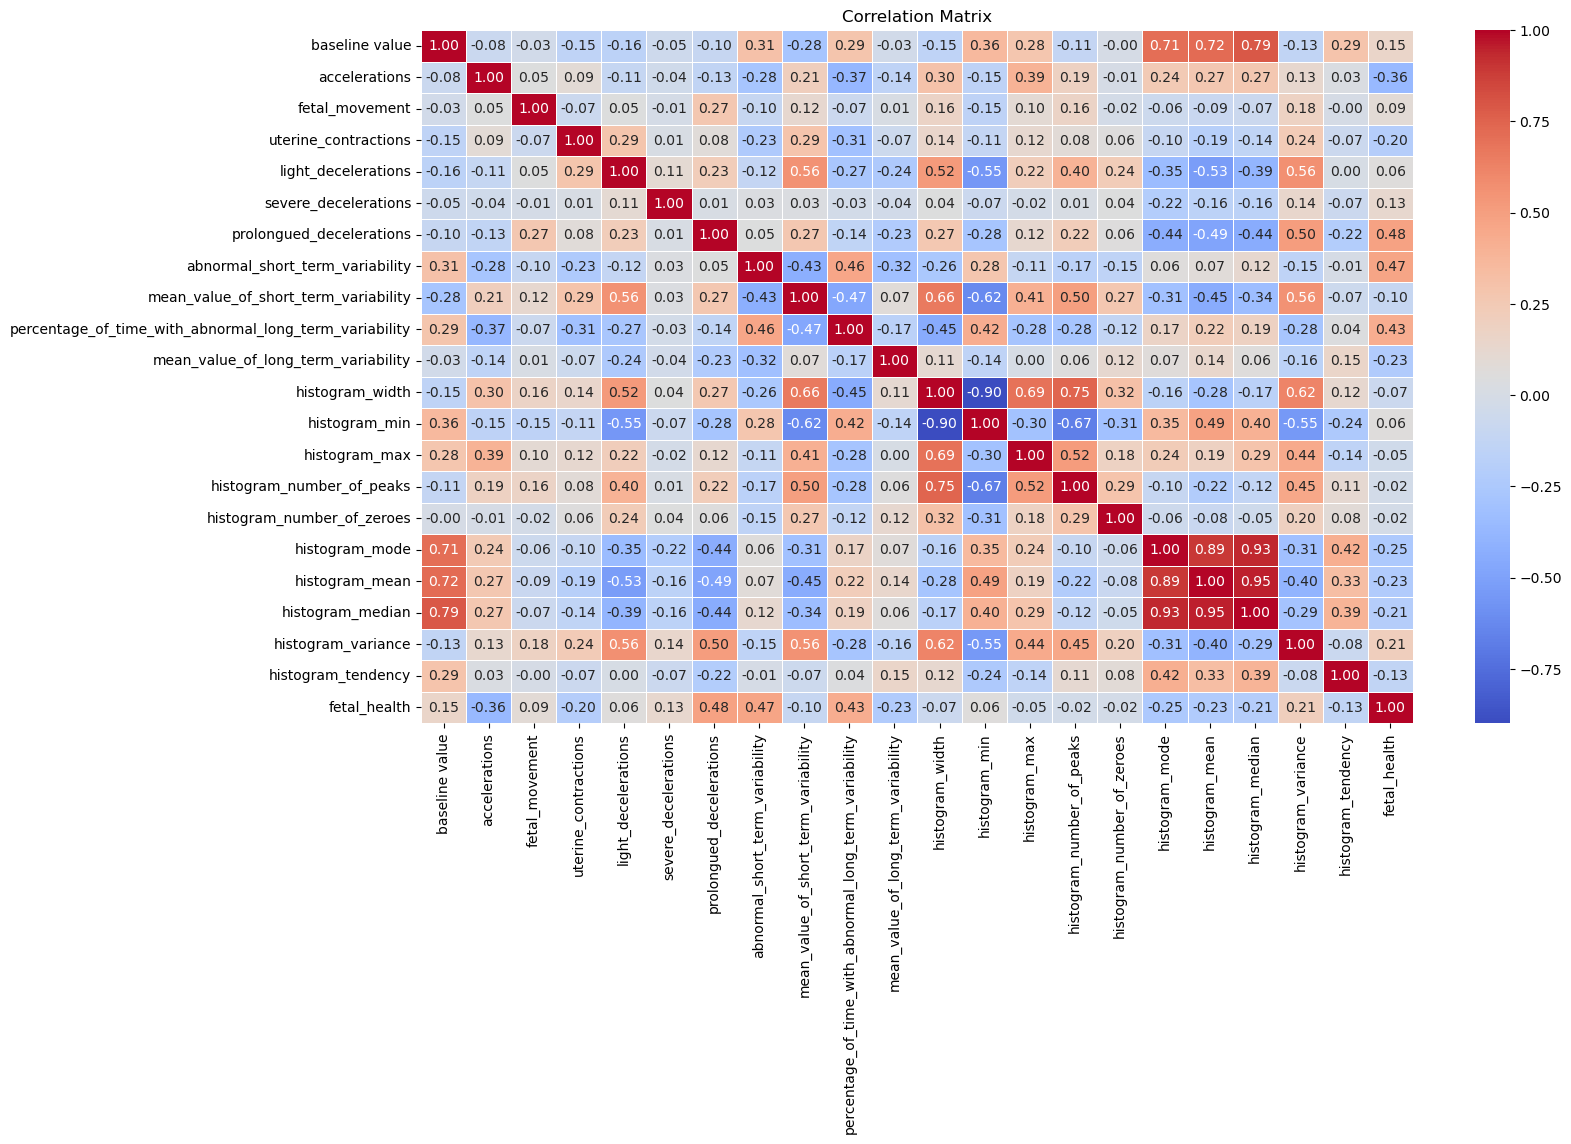

In [33]:
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidth=.5)

plt.title('Correlation Matrix')

save_plot('Correlation Matrix.png')

plt.show()

**Conclusion**: The correlation matrix shows that there is a slightly strong correlation between fetal health (target variable) and'accelerations', 'mean_value_of_long_term_variability', 'prolongued_decelarations', 'abonormal_short_term_variability', and 'percentage_of_time_with_abnormal_long_term_variability'.

### How does Fetal health change with respect to these variables?

#### Fetal Movement vs Accelerations by Fetal Health

Plot saved in plot directory as 'Fetal Movement vs Accelerations by Fetal Health.png' with dpi=300


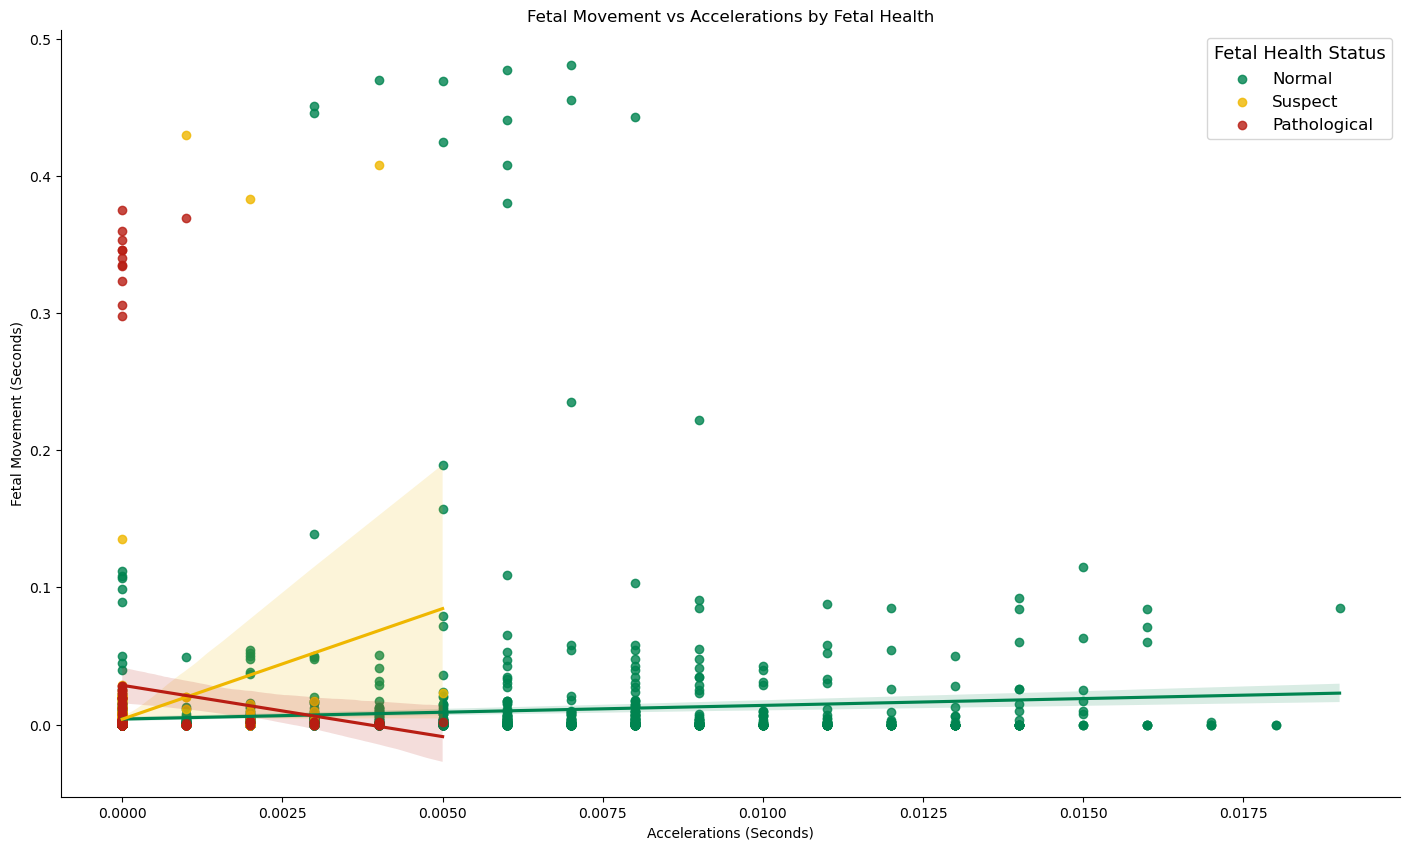

In [45]:
plot = sns.lmplot(data=df, x='accelerations', y='fetal_movement', hue='fetal_health', palette=colors, legend=None)

# Extract the handles and labels
handles, labels = plot.ax.get_legend_handles_labels()

# Define new labels
new_labels = ['Normal', 'Suspect', 'Pathological']

# Set the new labels
plot.ax.legend(handles=handles, labels=new_labels, title='Fetal Health Status', title_fontsize='13', fontsize='12')

# Adding titles and labels
plt.title('Fetal Movement vs Accelerations by Fetal Health')
plt.xlabel('Accelerations (Seconds)')
plt.ylabel('Fetal Movement (Seconds)')

# Saving plot
save_plot('Fetal Movement vs Accelerations by Fetal Health.png')

# Display the plot
plt.show()

**Conclusion** 

**Trend**: For the 'Normal' category, there's a slight positive trend indicating that as accelerations increase, fetal movement tends to increase slightly. The 'Suspect' category also seems to have a positive trend but with a wider confidence interval, suggesting more variability and less certainty about the trend. The 'Pathological' category shows a flat trend, suggesting little to no relationship between accelerations and fetal movement in this category.

**Spread of Data**: The spread of the data points is widest in the 'Normal' category and narrowest in the 'Pathological' category.

**Outliers**: There appear to be a few outliers, especially in the 'Normal' and 'Suspect' categories, where some data points are far from the main clusters.

**Interpretation**: In a healthy (Normal) state, there is a slight positive correlation between fetal movement and acceleration, while in a pathological state, this relationship is not evident.

#### Fetal Movement vs Prolongued Decelarations by Fetal Health

Plot saved in plot directory as 'Fetal Movement vs Prolongued Decelarations by Fetal Health.png' with dpi=300


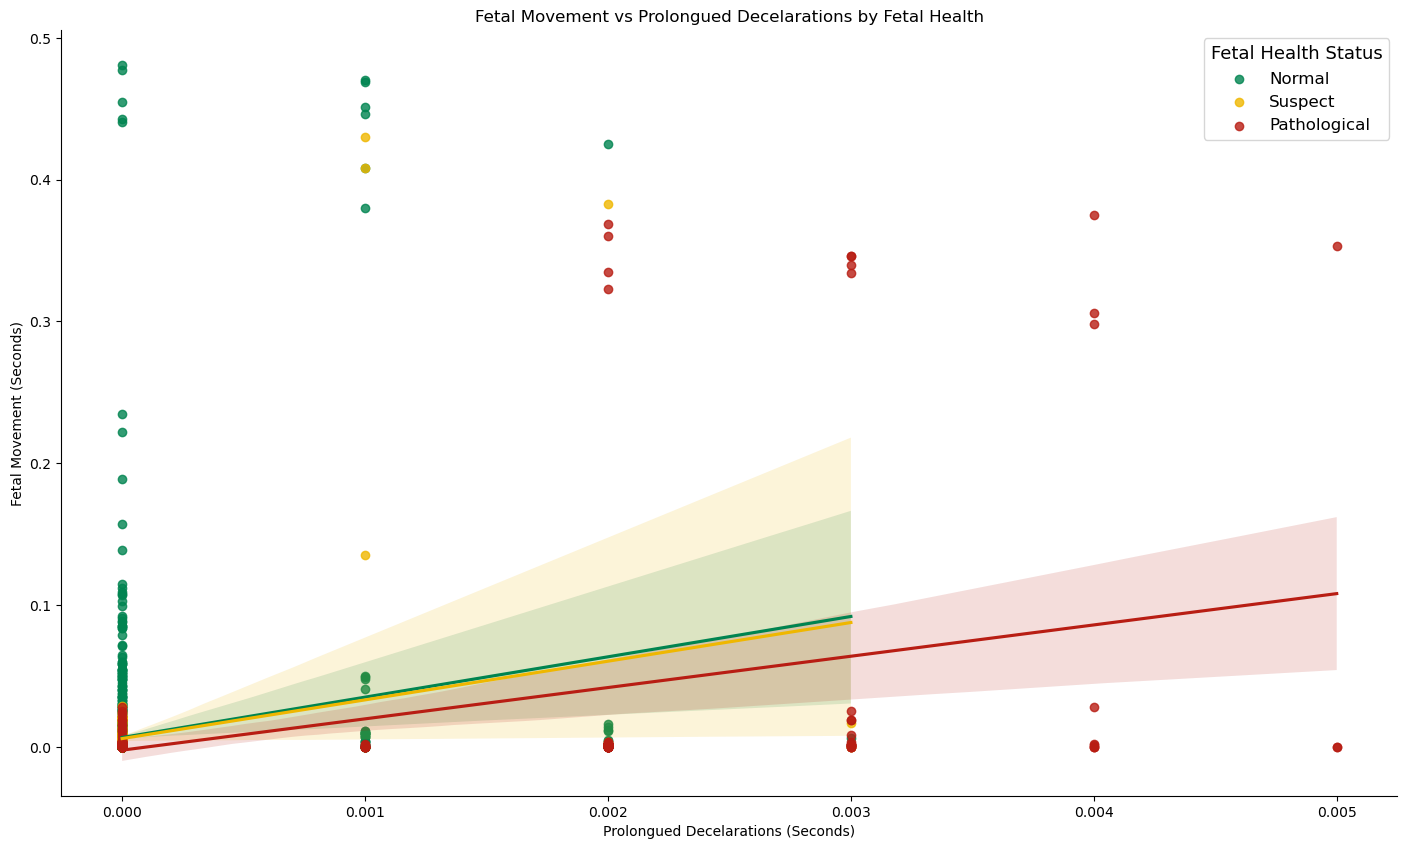

In [48]:
plot = sns.lmplot(data=df, x='prolongued_decelerations', y='fetal_movement', hue='fetal_health', palette=colors, legend=None)

# Extract the handles and labels
handles, labels = plot.ax.get_legend_handles_labels()

# Define new labels
new_labels = ['Normal', 'Suspect', 'Pathological']

# Set the new labels
plot.ax.legend(handles=handles, labels=new_labels, title='Fetal Health Status', title_fontsize='13', fontsize='12')

# Adding titles and labels
plt.title('Fetal Movement vs Prolongued Decelarations by Fetal Health')
plt.xlabel('Prolongued Decelarations (Seconds)')
plt.ylabel('Fetal Movement (Seconds)')

# Saving plot
save_plot('Fetal Movement vs Prolongued Decelarations by Fetal Health.png')

# Display the plot
plt.show()

**Conclusion** 

**Trend**: For the 'Normal' category, there's a positive trend indicating that as prolongued decelarations increase, fetal movement tends to increase but with a wide confidence interval. The 'Suspect' category also has a similar trend to the 'Normal' category however with a wider confidence interval indicating higher variability. However, in the 'Pathological' status, this relationship does not hold.

**Spread of Data**: There's a wide spread of data points, especially for the 'Pathological' category, indicating high variability in fetal movement at higher values of prolonged decelerations.

**Outliers**: There are several outliers, particularly in the 'Pathological' category, where individual cases show much higher fetal movement compared to the majority.

#### Fetal Movement vs Abnormal Short Term Variability by Fetal Health

Plot saved in plot directory as 'Fetal Movement vs Abnormal Short Term Variability by Fetal Health.png' with dpi=300


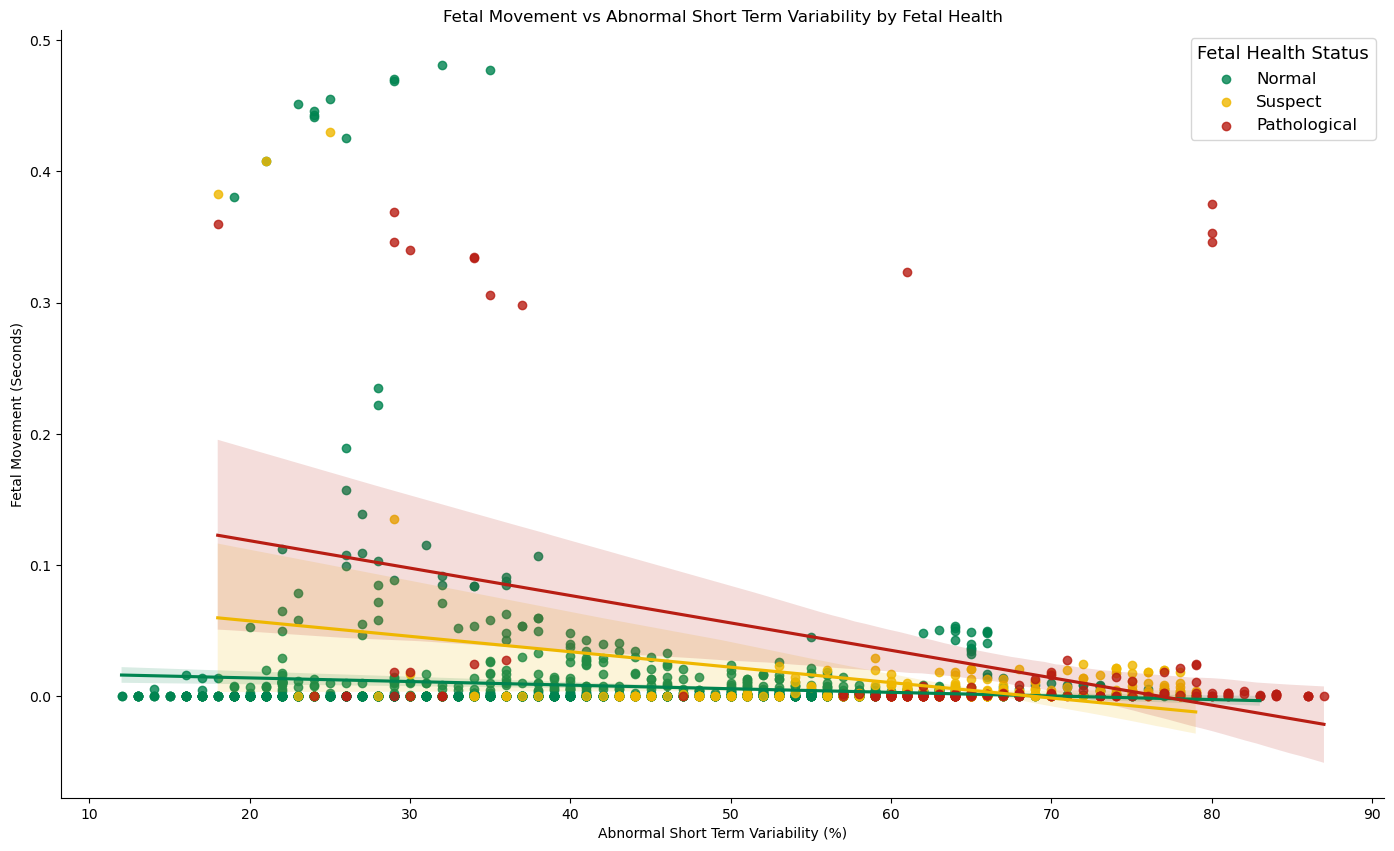

In [50]:
plot = sns.lmplot(data=df, x='abnormal_short_term_variability', y='fetal_movement', hue='fetal_health', palette=colors, legend=None)

# Extract the handles and labels
handles, labels = plot.ax.get_legend_handles_labels()

# Define new labels
new_labels = ['Normal', 'Suspect', 'Pathological']

# Set the new labels
plot.ax.legend(handles=handles, labels=new_labels, title='Fetal Health Status', title_fontsize='13', fontsize='12')

# Adding titles and labels
plt.title('Fetal Movement vs Abnormal Short Term Variability by Fetal Health')
plt.xlabel('Abnormal Short Term Variability (%)')
plt.ylabel('Fetal Movement (Seconds)')

# Saving plot
save_plot('Fetal Movement vs Abnormal Short Term Variability by Fetal Health.png')

# Display the plot
plt.show()

**Conclusion**

**Trend**: There seems to be a general negative correlation for 'Suspect' and 'Pathological' statuses between abnormal short term variability and fetal movement, suggesting that as variability in fetal heart rate increases, the fetal movement may decrease. This could indicate that higher variability might be associated with decreased fetal well-being.

**Spread**: Data points for 'Normal' status are clustered at the lower end of abnormal short term variability, suggesting that normal fetal health is associated with lower variability. The 'Suspect' and 'Pathological' data points spread out more as the percentage of abnormal short term variability increases.

#### Fetal Movement vs Mean Value of Long Term Variability by Fetal Health

Plot saved in plot directory as 'Fetal Movement vs Percentage of Time with Mean Value of Long Term Variability by Fetal Health.png' with dpi=300


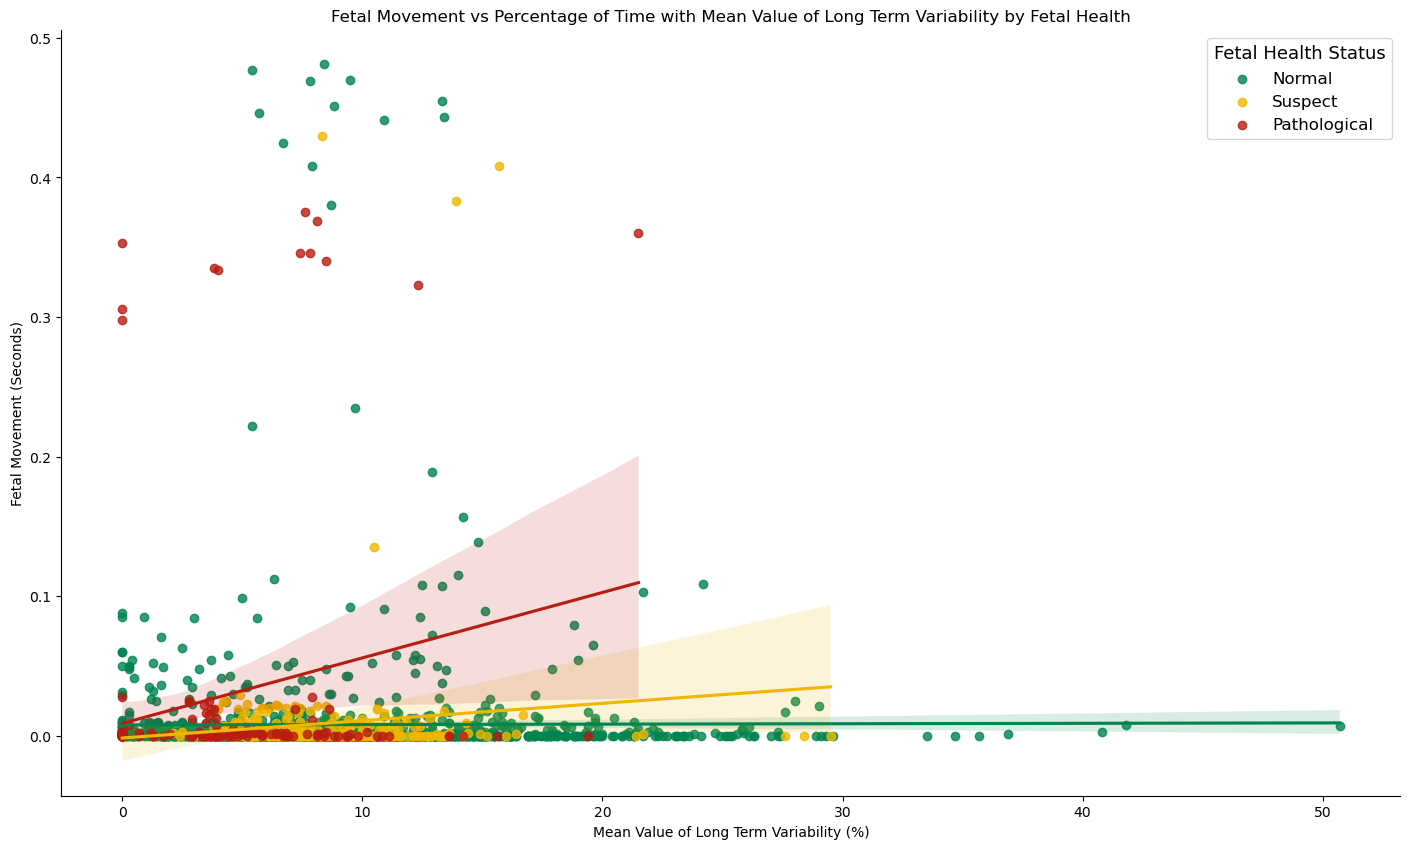

In [55]:
plot = sns.lmplot(data=df, x='mean_value_of_long_term_variability', 
                  y='fetal_movement', hue='fetal_health', palette=colors, legend=None)

# Extract the handles and labels
handles, labels = plot.ax.get_legend_handles_labels()

# Define new labels
new_labels = ['Normal', 'Suspect', 'Pathological']

# Set the new labels
plot.ax.legend(handles=handles, labels=new_labels, title='Fetal Health Status', title_fontsize='13', fontsize='12')

# Adding titles and labels
plt.title('Fetal Movement vs Percentage of Time with Mean Value of Long Term Variability by Fetal Health')
plt.xlabel('Mean Value of Long Term Variability (%)')
plt.ylabel('Fetal Movement (Seconds)')

# Saving plot
save_plot('Fetal Movement vs Percentage of Time with Mean Value of Long Term Variability by Fetal Health.png')

# Display the plot
plt.show()

**Conclusion**

**Trend**: The 'Normal' category exhibits a flat regression line, suggesting no significant correlation between the mean value of long term variability and fetal movement. The 'Suspect' category has a slightly positive slope, implying a potential weak positive correlation. The 'Pathological' category shows a more noticeable positive slope, which might indicate a stronger positive correlation between the mean value of long term variability and fetal movement within this group. The trends indicate that for 'Normal' fetuses, long term variability does not significantly affect fetal movement. However, for 'Pathological' fetuses, there seems to be an increase in fetal movement with an increase in the mean value of long term variability.

**Spread**: The 'Normal' and 'Suspect' categories show a dense clustering of data points at the lower end of the long term variability scale. The 'Pathological' data points are more spread out, indicating more variation in the mean value of long term variability.

### Outlier Detection

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 59.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 5.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


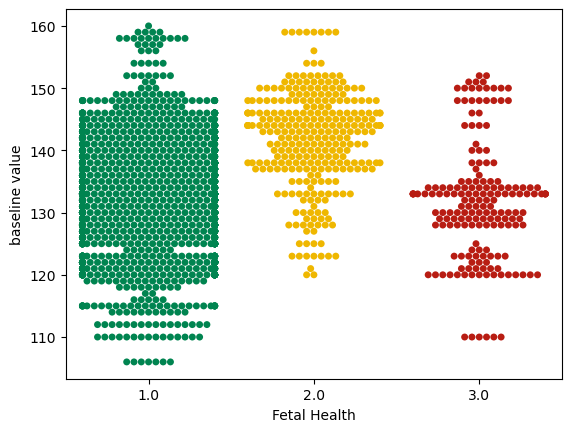

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 81.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 78.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 72.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


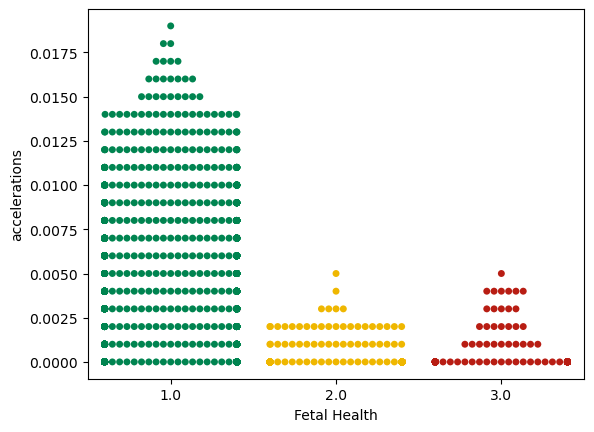

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 91.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 79.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 73.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


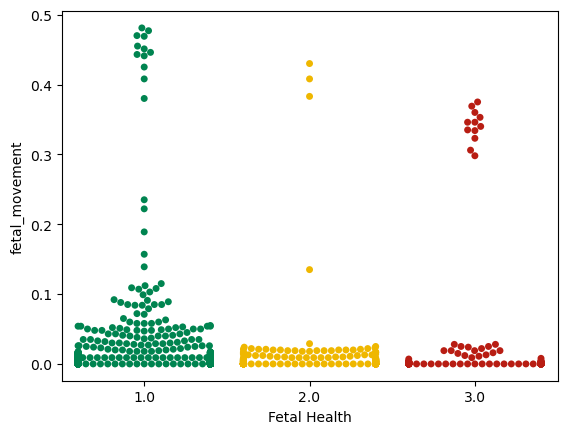

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 85.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 46.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


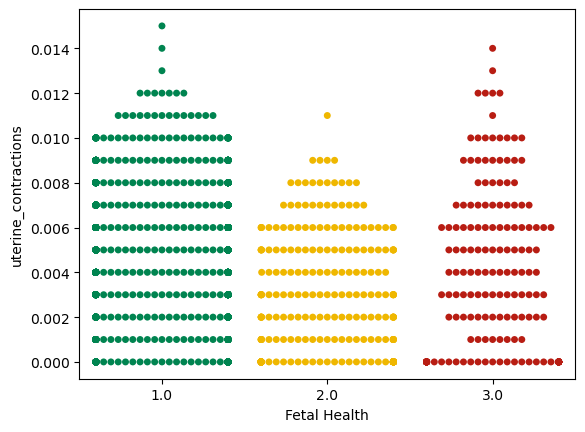

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 86.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 76.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 29.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


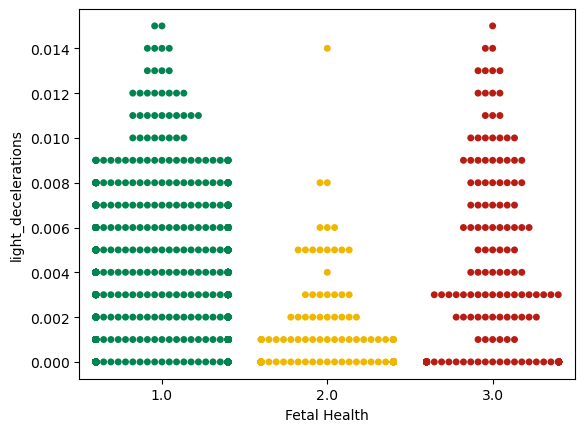

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 98.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 93.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 85.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


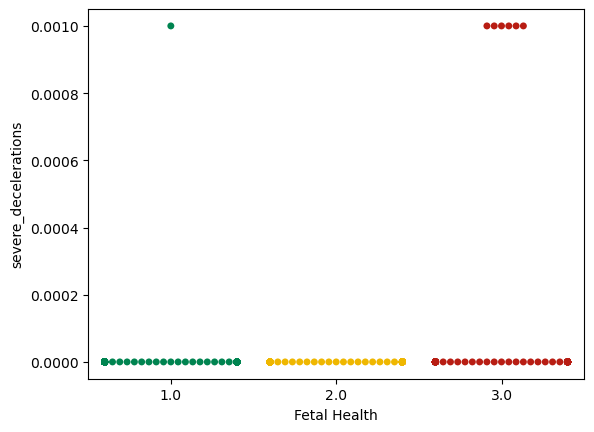

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 96.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 88.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 54.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


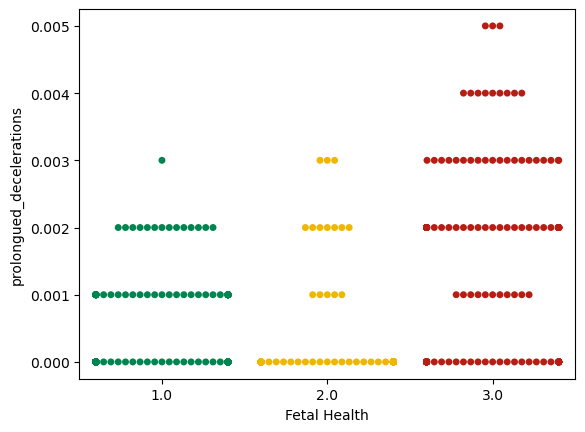

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 65.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 16.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


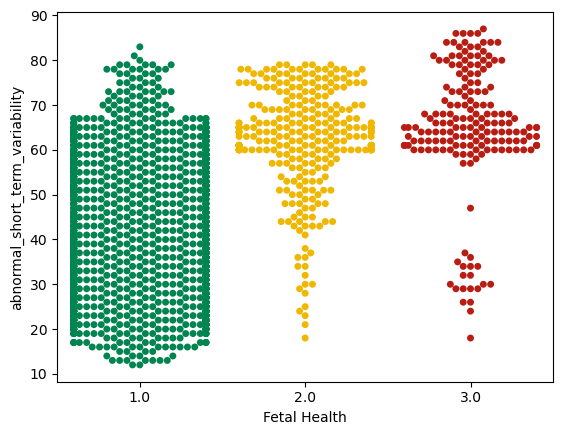

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 79.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 60.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 17.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


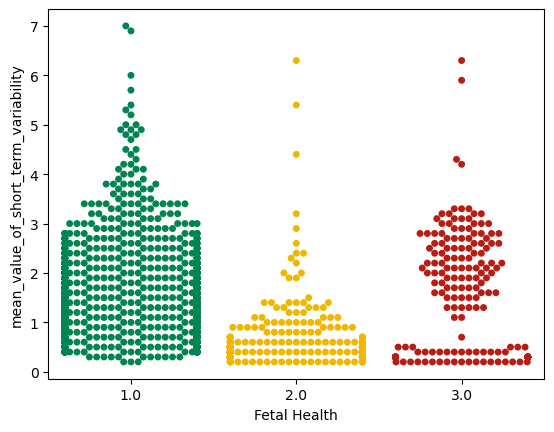

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 80.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 51.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


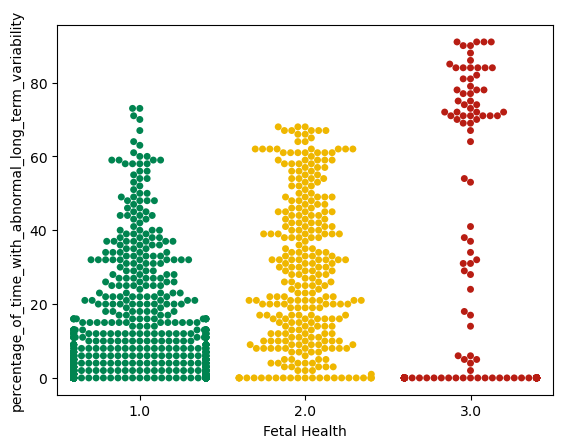

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 73.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 35.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


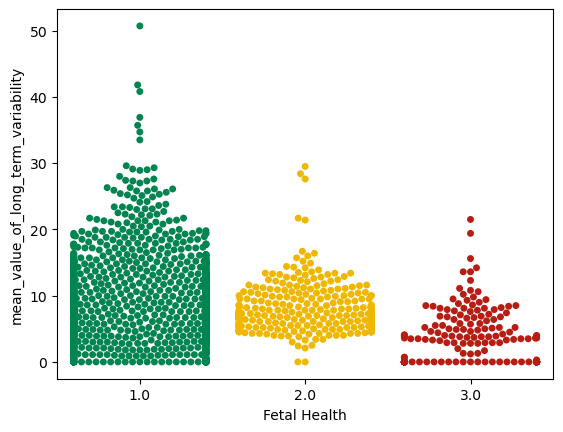

In [60]:
cols = ['baseline value', 'accelerations', 'fetal_movement', 'uterine_contractions', 'light_decelerations',
         'severe_decelerations', 'prolongued_decelerations', 'abnormal_short_term_variability', 
         'mean_value_of_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability',
         'mean_value_of_long_term_variability']

for col in cols:
    sns.swarmplot(x=df['fetal_health'], y=df[col], palette=colors)
    
    plt.xlabel('Fetal Health')
    plt.ylabel(col)
    plt.show()

**Conclusion**: There exists outliers in the dataset. However, because of the context of the problem being in the medical sector these outliers may prove valuable to medical experts, therefore there won't be a need to remove these values.

## Pre-Processing Data

To prepare the data for model building, we need to check the range of the dataset. The below plot shows that the range of the features are different and will therefore need to be scaled to the same range.

Plot saved in plot directory as 'Range of dataset before model building.png' with dpi=300


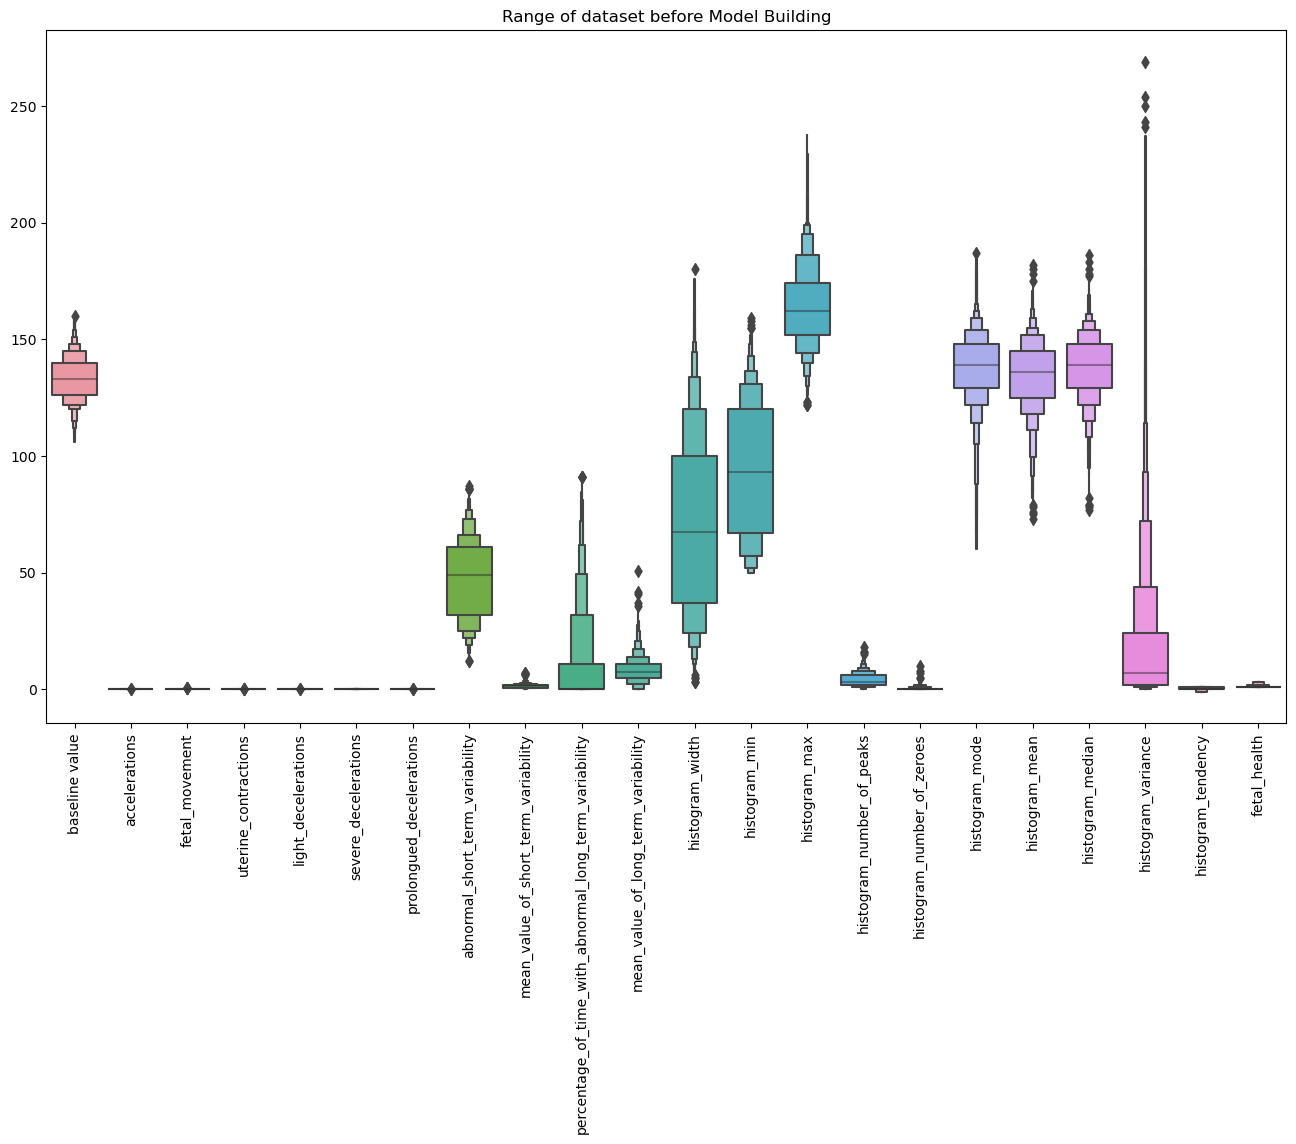

In [69]:
sns.boxenplot(data=df)

plt.xticks(rotation=90)

plt.title('Range of dataset before Model Building')

save_plot('Range of dataset before model building.png')
plt.show()

### Standard Scaler

In [66]:
# assigning X and y variables
X = df.drop(['fetal_health'], axis=1)
y=df['fetal_health']

# Set up standard scaler
col_names = list(X.columns)
s_scaler = StandardScaler()
df_scaled = s_scaler.fit_transform(X)
df_scaled = pd.DataFrame(df_scaled, columns=col_names)
df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,4.161509e-16,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-1.803982e-16,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.958452e-15,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-2.625683e-15,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.127706e-15,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,7.254767e-16,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,4.324961e-15,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,2.687304e-16,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,-2.481552e-16,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,2.291362e-15,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


Plot saved in plot directory as 'Range of dataset after model building.png' with dpi=300


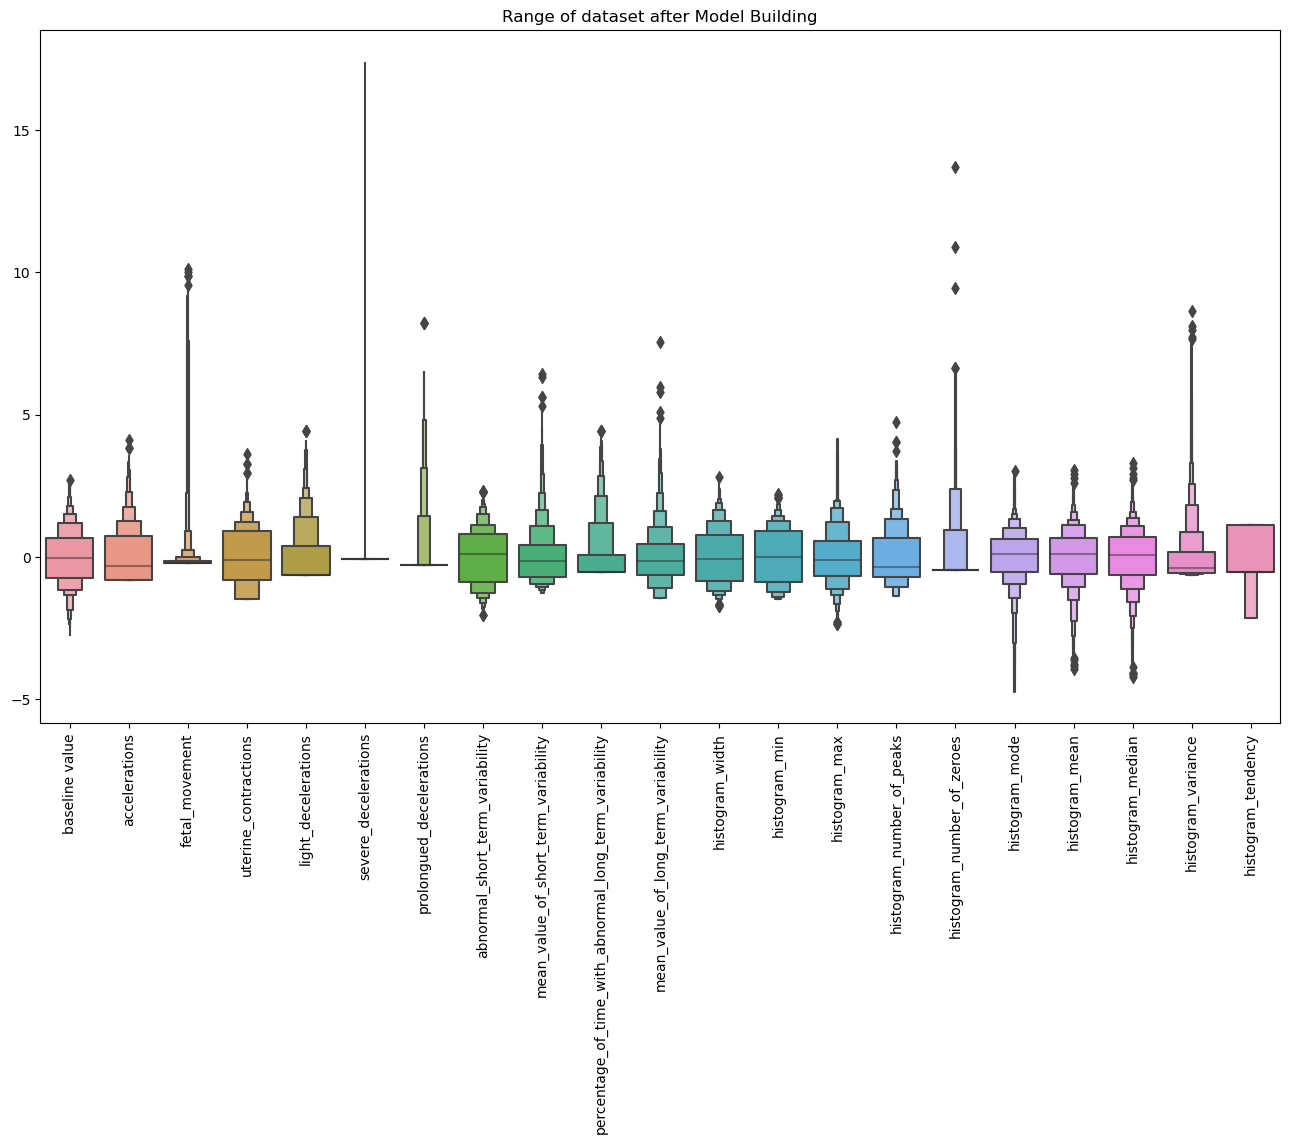

In [70]:
sns.boxenplot(data=df_scaled)

plt.xticks(rotation=90)

plt.title('Range of dataset after Model Building')

save_plot('Range of dataset after model building.png')
plt.show()

#### Splitting dataset

In [74]:
X_train, X_test, y_train,y_test = train_test_split(df_scaled,y,test_size=0.3,random_state=42)

## Model Building

#### Model Selection

In [80]:
lr_model = Pipeline([('lr_classifier', LogisticRegression(random_state=42))])
dt_model = Pipeline([('dt_classifier', DecisionTreeClassifier(random_state=42))])
rf_model = Pipeline([('rf_classifier', RandomForestClassifier(random_state=42))])
knn_model = Pipeline([('knn_classifier', KNeighborsClassifier())])
svc_model = Pipeline([('svc_classifier', SVC())])

pipelines = [lr_model, dt_model, rf_model, knn_model, svc_model]
pipe_dict = {0: 'Logistic Regression', 1: 'Decision Tree', 2: 'Random Forest', 3: 'KNN', 4: 'SVC'}

for pipe in pipelines:
    pipe.fit(X_train, y_train)
    
#cross validation on accuracy 
cv_results_accuracy = []
for i, model in enumerate(pipelines):
    cv_score = cross_val_score(model, X_train,y_train, cv=10 )
    cv_results_accuracy.append(cv_score)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

Logistic Regression: 0.897170 
Decision Tree: 0.916683 
Random Forest: 0.938187 
KNN: 0.894504 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

SVC: 0.906594 


The best model is Random Forest, therefore I will use hyper parameter tuning with grid search to build a better model.

#### Hyper Parameter Tuning

In [81]:
parameters = {
    'n_estimators': [100, 150, 200, 500, 700, 900],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4,6,8,12,14,16],
    'criterion': ['gini', 'entropy'],
}

rfc_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters, cv= 5)
rfc_cv.fit(X_train, y_train)

rfc_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'sqrt',
 'n_estimators': 900}

In [82]:
rf_model = RandomForestClassifier(**rfc_cv.best_params_)
rf_model.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

## Evaluation

### Evaluation Metrics

In [86]:
model_evaluator(y_test, predictions, "Random Forest Classifier")

********* RANDOM FOREST CLASSIFIER Results *********
Accuracy    :  0.9482758620689655
Recall      :  0.9482758620689655
Precision   :  0.9475673568699188
F1 Score    :  0.9482758620689655


********* RANDOM FOREST CLASSIFIER Classification Report *********
              precision    recall  f1-score   support

         1.0       0.96      0.98      0.97       496
         2.0       0.92      0.78      0.84       101
         3.0       0.88      0.93      0.90        41

    accuracy                           0.95       638
   macro avg       0.92      0.90      0.91       638
weighted avg       0.95      0.95      0.95       638



**Results**:

This report breaks down the performance for each class (Normal (1.0), Suspect (2.0), Pathological (3.0)).

**Precision per Class**: Indicates the accuracy of positive predictions for each class. For example, for class 1.0, 96% of the instances predicted as class 1.0 were correct.

**Recall per Class**: Shows how well the model is at detecting each class. For class 1.0, the model correctly identified 98% of all actual class 1.0 instances.

**F1-Score per Class**: Combines precision and recall into a single metric for each class. Higher values indicate better performance.

**Support**: The number of actual occurrences of each class in the dataset. For instance, there were 496 instances of class 1.0.
The results of the  evaluation metrics and confusion matrix help us draw the following conclusions.

**Macro Average**: The average of the metric computed independently for each class, treating all classes equally.

**Weighted Average**: The average of the metric weighted by the support (the number of true instances for each class). This accounts for class imbalance.

**Interpretation**: The model is performing well overall with high accuracy, precision, recall, and F1 scores.
However, it seems to perform better on class 1.0 compared to class 2.0 and 3.0, which might be due to class imbalance as earlier identified or other factors. The difference between the macro average and weighted average in precision, recall, and F1 score provides evidence of the class imbalance in the dataset. The weighted average is higher, indicating that the model performs better on the more prevalent classes.

### Confusion Matrix

Plot saved in plot directory as 'Confusion Matrix.png' with dpi=300


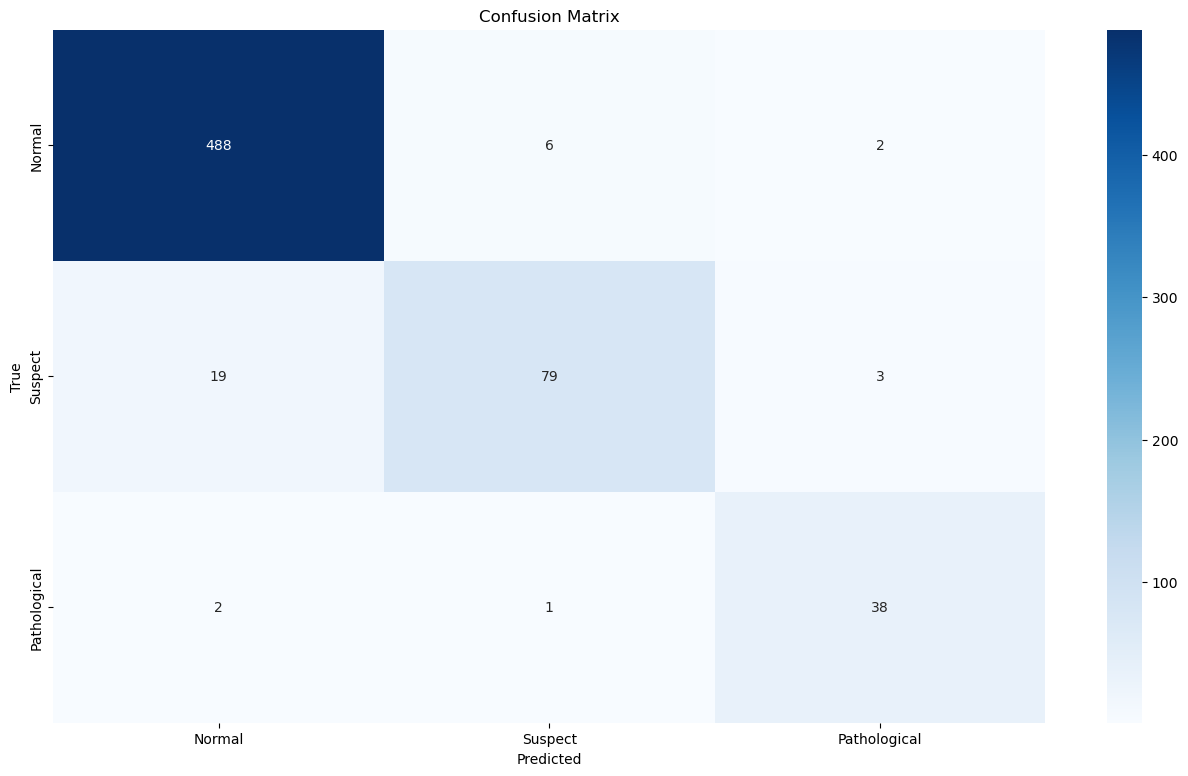

In [93]:
plot_confusion_matrix(y_test, predictions, ['Normal', 'Suspect', 'Pathological'], title='Confusion Matrix', cmap='Blues')

### Confusion Matrix Results

**Interpretation of Cells**:

- Top-left cell (Normal, Normal): The model predicted 'Normal' correctly 488 times.
- Middle cell (Suspect, Suspect): The model predicted 'Suspect' correctly 79 times.
- Bottom-right cell (Pathological, Pathological): The model predicted 'Pathological' correctly 38 times.


**Errors**:

- Top-middle cell (Normal, Suspect): The model incorrectly predicted 6 instances of 'Normal' as 'Suspect'.
- Top-right cell (Normal, Pathological): The model incorrectly predicted 2 instances of 'Normal' as 'Pathological'.
- Middle-left cell (Suspect, Normal): The model incorrectly predicted 19 instances of 'Suspect' as 'Normal'.
- Middle-right cell (Suspect, Pathological): The model incorrectly predicted 3 instances of 'Suspect' as 'Pathological'.
- Bottom-left cell (Pathological, Normal): The model incorrectly predicted 2 instances of 'Pathological' as 'Normal'.
- Bottom-middle cell (Pathological, Suspect): The model incorrectly predicted 1 instance of 'Pathological' as 'Suspect'.

**Overall Performance**: The model is most accurate with the 'Normal' class, with a high number of correct predictions and a relatively small number of false predictions.The model performs reasonably well on the 'Pathological' class. The 'Suspect' class has the most misclassifications relative to its true count, with a notable number of false negatives (predicted as 'Normal').